In [ ]:
%pip install -r ../requirements.txt

In [1]:
base_dir: bool = False

In [4]:
import os, sys

if not base_dir:
    os.chdir('../')
    base_dir = True

import numpy as np, pandas as pd, matplotlib.pyplot as plt, sklearn, torch

from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn

from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score

from utils.data_tools import inbreast, cbis_ddsm, image_processing
from utils.models import models

In [5]:
inbreast.download()
cbis_ddsm.download()

Path already exists for INBreast!
Path already exists for CBIS-DDSM!


In [6]:
# Testing Data, avg time 20 min

class cbis_ddsm_data:

    x_train, x_test, y_train, y_test = data = cbis_ddsm.get_images(split_by_patient_id=True)

class inbreast_data:

    x_train, x_test, y_train, y_test = data = inbreast.get_images()

    x, y = np.concatenate([x_train, x_test]), np.concatenate([y_train, y_test])

409/409


Pixel Distribution: shape (224, 224), mean 0.224420, std 0.272162, min 0.000000, max 1.000000, unique 256


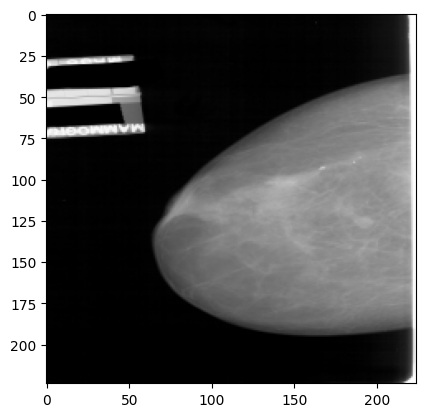

In [7]:
import matplotlib.pyplot as plt

img = cbis_ddsm_data.x_train[5]

print(
    f"Pixel Distribution: shape {img.shape}, mean {np.mean(img):2f}, std {np.std(img):2f}, min {np.min(img):2f}, max {np.max(img):2f}, unique {np.unique(img.flatten()).shape[0]}"
)

plt.imshow(
    img,
    cmap='gray',
)

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-20, 20))], p=0.2),
    transforms.ToTensor(),
])

In [9]:
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, x, y, transform=transform):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.x.__len__()

    def __getitem__(self, idx):

        #image = torch.tensor(np.expand_dims(self.x[idx], axis=0), dtype=torch.float32)
        image = self.x[idx]
        if self.transform:
            image = self.transform(Image.fromarray(image))

        label = torch.tensor([0, 1] if self.y[idx] else [1, 0], dtype=torch.float32)

        return image, label

def get_loader(x, y, batch_size=32, transform=transform):

    loader = DataLoader(CustomImageDataset(x, y, transform=transform), batch_size=batch_size, shuffle=True)

    return loader

def get_loader_test(x, y, batch_size=32, transform=transform):

    loader = DataLoader(CustomImageDataset(x, y, transform=transform), batch_size=batch_size)

    return loader

In [10]:
l = get_loader(cbis_ddsm_data.x_train, cbis_ddsm_data.y_train)
vl = get_loader(cbis_ddsm_data.x_test, cbis_ddsm_data.y_test)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from IPython.display import clear_output

class CNNModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=1)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)

    def on_train_epoch_end(self):
        clear_output()
        return super().on_train_epoch_end()

    def forward(self, x):
        """
        Returns Logits
        """
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch

        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        # print(f'Train Crossentropy', loss.item())
        # print(f'Train Accuracy', (torch.argmax(F.softmax(logits)) == y.long()).count_nonzero() / F.softmax(logits).shape[0])
        # clear_output(wait=True)
        return loss

    def val_dataloader(self):
        return get_loader(cbis_ddsm_data.x_test, cbis_ddsm_data.y_test)

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)

        loss = F.cross_entropy(logits, targets)

        # print(f'Val Crossentropy', loss.item())
        # print(f'Val Accuracy', (torch.argmax(F.softmax(logits)) == targets.long()).count_nonzero() / F.softmax(logits).shape[0])
        self.log('val_loss', loss)
        # clear_output(wait=True)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        predictions = F.softmax(logits, dim=-1)
        return predictions

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [28]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import TQDMProgressBar

model = CNNModel()
trainer = Trainer(max_epochs=25, enable_progress_bar=True)

trainer.fit(model, l)
pass

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 18/18 [00:06<00:00,  2.58it/s, v_num=22]


In [29]:
testl = get_loader_test(inbreast_data.x, inbreast_data.y)

y_pred = trainer.predict(model, testl)

print(f"""
Test Loss: {F.cross_entropy(torch.concat(y_pred), torch.from_numpy(inbreast_data.y).long())}
Accuracy: {(torch.argmax(torch.concat(y_pred), dim=1) == torch.from_numpy(inbreast_data.y).long()).count_nonzero() / torch.concat(y_pred).shape[0]}
""")

Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 16.80it/s]

Test Loss: 0.3837970793247223
Accuracy: 0.9608802199363708



In [30]:
torch.save(model.state_dict(), 'models/SAMMY.pt')

In [32]:
%reload_ext tensorboard
%tensorboard --logdir=./lightning_logs/

Launching TensorBoard...